# Journal 2022-09-21
Game of Life as a matrix multiplication and lookup

In [1]:
%load_ext autoreload
%autoreload 2

In [245]:
import numpy as np
import scipy
import networkx as nx
import graphblas as gb
import jax
import jax.numpy as jnp
from jax.experimental import sparse
import matplotlib.pyplot as plt
import seaborn as sns

In [48]:
G = nx.grid_2d_graph(3, 3, periodic=True)

In [51]:
list(nx.neighbors(G, (0,0)))

[(1, 0), (0, 1), (2, 0), (0, 2)]

In [52]:
nx.adjacency_matrix(G).todense()

<ipython-input-52-1bde6f730118>:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  nx.adjacency_matrix(G).todense()


matrix([[0, 1, 1, 1, 0, 0, 1, 0, 0],
        [1, 0, 1, 0, 1, 0, 0, 1, 0],
        [1, 1, 0, 0, 0, 1, 0, 0, 1],
        [1, 0, 0, 0, 1, 1, 1, 0, 0],
        [0, 1, 0, 1, 0, 1, 0, 1, 0],
        [0, 0, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 0, 1, 0, 0, 0, 1, 1],
        [0, 1, 0, 0, 1, 0, 1, 0, 1],
        [0, 0, 1, 0, 0, 1, 1, 1, 0]])

In [58]:
# diagonal edges
[((i, j), ((k+d) % 3, l)) for ((i,j), (k,l)) in G.edges() for d in (1, -1)  if i == k]

[((0, 0), (1, 1)),
 ((0, 0), (2, 1)),
 ((0, 0), (1, 2)),
 ((0, 0), (2, 2)),
 ((0, 1), (1, 2)),
 ((0, 1), (2, 2)),
 ((1, 0), (2, 1)),
 ((1, 0), (0, 1)),
 ((1, 0), (2, 2)),
 ((1, 0), (0, 2)),
 ((1, 1), (2, 2)),
 ((1, 1), (0, 2)),
 ((2, 0), (0, 1)),
 ((2, 0), (1, 1)),
 ((2, 0), (0, 2)),
 ((2, 0), (1, 2)),
 ((2, 1), (0, 2)),
 ((2, 1), (1, 2))]

In [59]:
def make_2d_eight_neighbor(n_grid):
    G = nx.grid_2d_graph(n_grid, n_grid, periodic=True)
    diagonal_edges = [
        ((i, j), ((k+d) % n_grid, l)) 
        for ((i,j), (k,l)) in G.edges() for d in (1, -1)  if i == k
    ]
    G.add_edges_from(diagonal_edges)
    return G

In [77]:
G = make_2d_eight_neighbor(20)

In [78]:
list(nx.neighbors(G, (0,0)))

[(1, 0), (0, 1), (19, 0), (0, 19), (1, 1), (19, 1), (1, 19), (19, 19)]

<ipython-input-79-cad78bc27077>:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  _ = plt.imshow(nx.adjacency_matrix(G).astype(np.uint8).todense())


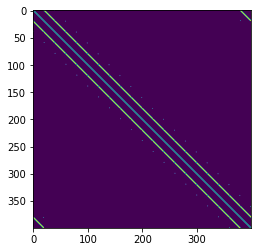

In [79]:
_ = plt.imshow(nx.adjacency_matrix(G).astype(np.uint8).todense())

# Life as a sparse matrix operation

In [90]:
def make_adjacency_matrix(n_grid):
    G = make_2d_eight_neighbor(n_grid)
    mat = nx.to_scipy_sparse_array(G, format='coo')
    return mat

In [91]:
mat = make_adjacency_matrix(100)

In [102]:
x = np.random.randint(2, size=(100*100))
neighbor_count = mat @ x

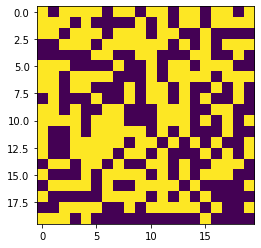

In [106]:
_ = plt.imshow(x.reshape((100, 100))[:20, :20])

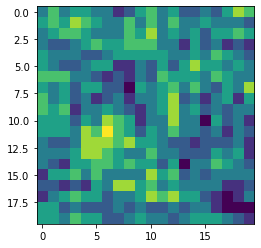

In [105]:
_ = plt.imshow(neighbor_count.reshape((100, 100))[:20, :20])

In [109]:
make_adjacency_matrix(3) @ np.array([1, 0, 0, 0, 1, 0, 0, 0, 0])

array([1, 2, 2, 2, 1, 2, 2, 2, 2])

In [110]:
def life(adj_mat, x):
    neighbor_count = adj_mat @ x
    lut = np.array(
        [
            [0, 0, 0, 1, 0, 0, 0, 0, 0],
            [0, 0, 1, 1, 0, 0, 0, 0, 0]
        ])
    x_next = lut[x, neighbor_count]
    return x_next

In [171]:
n_grid = 100
A = make_adjacency_matrix(n_grid)
x = np.random.randint(2, size=n_grid*n_grid)

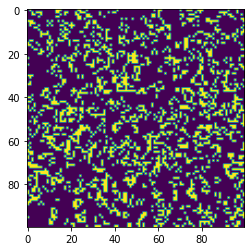

In [174]:
_ = plt.imshow(x.reshape((n_grid, n_grid)))
x_next = life(A, x)
x = x_next


## Efficiency
Constructing the neighbour graph is too slow - list construction in Python?  Better to directly create the adjacency matrix 

In [187]:
make_adjacency_matrix(10).todense()[:3, :]

array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1,

In [207]:
sorted([np.ravel_multi_index(
    ((0 + v) % 10, (0 + h) % 10), (10, 10)) 
 for v in (-1, 0, 1) for h in (-1, 0, 1) 
 if not(h == 0 and v == 0)])

[1, 9, 10, 11, 19, 90, 91, 99]

In [206]:
np.nonzero(make_adjacency_matrix(10).todense()[0, :])

(array([ 1,  9, 10, 11, 19, 90, 91, 99]),)

In [216]:
step = np.array([[v, h] for v in (0, 1, -1) for h in (0, 1, -1)])
step

array([[ 0,  0],
       [ 0,  1],
       [ 0, -1],
       [ 1,  0],
       [ 1,  1],
       [ 1, -1],
       [-1,  0],
       [-1,  1],
       [-1, -1]])

In [218]:
pt = np.array([0, 0])
n = np.ravel_multi_index((pt + step).T % 10, (10, 10))
np.vstack((np.repeat(n[0], len(n[1:])), n[1:]))

array([[ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  9, 10, 11, 19, 90, 91, 99]])

In [226]:
pts = np.vstack(
    (np.kron(np.arange(10), np.ones(10)), 
    np.kron(np.ones(10), np.arange(10)))
).astype(np.uint8)
pts

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1,
        2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3,
        4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5,
        6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7,
        8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]], dtype=uint8)

In [227]:
np.ravel_multi_index(pts, (10,10))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [236]:
pt_start = np.kron(pts, np.ones(8, dtype=np.uint8))

In [239]:
pt_neighbour = (pt_start + np.kron(np.ones(pts.shape[1], dtype=np.uint8), step[1:, :].T)) % 10

In [240]:
row = np.ravel_multi_index(pt_start, (10, 10))
col = np.ravel_multi_index(pt_neighbour, (10, 10))

In [244]:
row[:8]

array([0, 0, 0, 0, 0, 0, 0, 0])

In [243]:
col[:8]

array([ 1,  9, 10, 11, 19, 90, 91, 99])

In [249]:
def make_adj(n_grid):
    step = np.array([[v, h] for v in (0, 1, -1) for h in (0, 1, -1)])
    pts = np.vstack(
        (np.kron(np.arange(n_grid), np.ones(n_grid)), 
        np.kron(np.ones(n_grid), np.arange(n_grid)))
    ).astype(np.uint8)
    pt_start = np.kron(pts, np.ones(8, dtype=np.uint8))
    pt_neighbour = (pt_start + np.kron(np.ones(pts.shape[1], dtype=np.uint8), step[1:, :].T)) % n_grid
    row = np.ravel_multi_index(pt_start, (n_grid, n_grid))
    col = np.ravel_multi_index(pt_neighbour, (n_grid, n_grid))
    data = np.ones_like(row, dtype=np.uint8)
    adj_mat = scipy.sparse.coo_array((data, (row, col)), shape=(n_grid*n_grid, n_grid*n_grid))
    return adj_mat

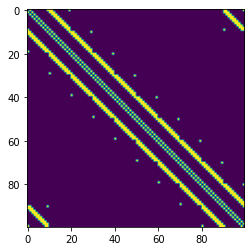

In [257]:
_ = plt.imshow(make_adj(10).todense())

In [260]:
%timeit make_adj(100)

25.3 ms ± 748 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [261]:
# Original version
%timeit make_adjacency_matrix(100)

224 ms ± 24.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Sheafs?
Think about expanding the adjacency matrix to allow d-dimensional state at each node with restriction maps between nodes (whil preserving sparsity)

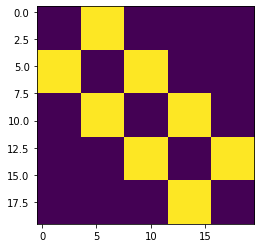

In [276]:
_ = plt.imshow(np.kron(make_adj(10).todense(), np.ones((4,4), dtype=np.uint8))[:20, :20])

In [279]:
A = make_adj(100)
A

<10000x10000 sparse array of type '<class 'numpy.uint8'>'
	with 80000 stored elements in COOrdinate format>

In [281]:
from collections import defaultdict

In [285]:
tform_lookup = defaultdict(lambda : np.zeros((3, 3)))

In [286]:
for i in range(len(A.row)):
    tform_lookup[A.row[i], A.col[i]] = np.eye(3)

In [290]:
tform_lookup[0,1]

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])